# 00. 
> 앙상블(ensemble) 방법론, 특히 스태킹(Stacking)이라고 알려진 앙상블의 변형에 대한 매우 기본적이고 간단한 입문서입니다. 간단히 말하면, 스태킹은 처음 수준(base)으로 몇 가지 기본 분류기의 예측을 사용하고, 그 다음 두 번째 수준에서 다른 모델을 사용하여 처음 수준의 예측으로부터 출력을 예측합니다.

In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib.inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)

from sklearn.svm import SVC
from sklearn.cross_validation import KFold

UsageError: Line magic function `%matplotlib.inline` not found.


---

# 01. 
> 먼저 데이터를 탐색하고, 가능한 특성 엔지니어링 기회를 식별하고, 범주형 특성을 숫자로 인코딩

In [27]:
train = pd.read_csv("C:/Users/daum0/Downloads/카카오톡 받은 파일/DataFiery/train_titanic.csv")
test = pd.read_csv("C:/Users/daum0/Downloads/카카오톡 받은 파일/DataFiery/test_titanic.csv")

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

In [28]:
full_data = [train, test]

# 일부 추가한 특성
# 이름의 길이를 나타내는 특성 추가
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# 타이타닉에 객실이 있는지 여부를 나타내는 특성 추가
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Sina의 특성 엔지니어링 아이디어 사용
# SibSp와 Parch를 결합하여 FamilySize라는 새로운 특성 생성
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# FamilySize로부터 IsAlone이라는 새로운 특성 생성
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Embarked 열의 모든 NULL 값 제거
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Fare 열의 모든 NULL 값 제거하고 새로운 특성 CategoricalFare 생성
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# 새로운 특성 CategoricalAge 생성
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# 승객 이름에서 제목을 추출하는 함수 정의
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # 제목이 있는 경우 추출하여 반환
    if title_search:
        return title_search.group(1)
    return ""
# 승객 이름에서 제목을 나타내는 새로운 특성 Title 생성
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# 모든 일반적이지 않은 제목을 하나의 그룹인 "Rare"로 통합
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # 성별 매핑
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # 제목 매핑
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # 탑승지 매핑
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # 운임 매핑
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # 나이 매핑
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

C:\Users\daum0\AppData\Local\Temp\ipykernel_16676\1706701169.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list


In [29]:
# 특성 선택
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']  # 삭제할 열들을 나열한 리스트를 생성
train = train.drop(drop_elements, axis=1)  # 훈련 데이터셋에서 삭제할 열들을 제거
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis=1)  # 'CategoricalAge', 'CategoricalFare' 열을 제거
test = test.drop(drop_elements, axis=1)  # 테스트 데이터셋에서 삭제할 열들을 제거

> 데이터를 정제하고 관련 정보를 추출하고 범주형 열을 삭제한 후에, 이제 우리의 특성은 모두 숫자형이어야 함, 이는 기계 학습 모델에 입력하기에 적합한 형식, 그전에 변형된 데이터셋에 대한 간단한 상관 관계와 분포 플롯을 생성하여 확인!

In [4]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


# 02. 피어슨 상관 관계 히트맵
>-  각 특성이 다음 특성과 얼마나 관련되어 있는지를 확인하기 위해 일부 상관 관계 플롯을 생성후 확인

<Axes: title={'center': 'Pearson Correlation of Features'}>

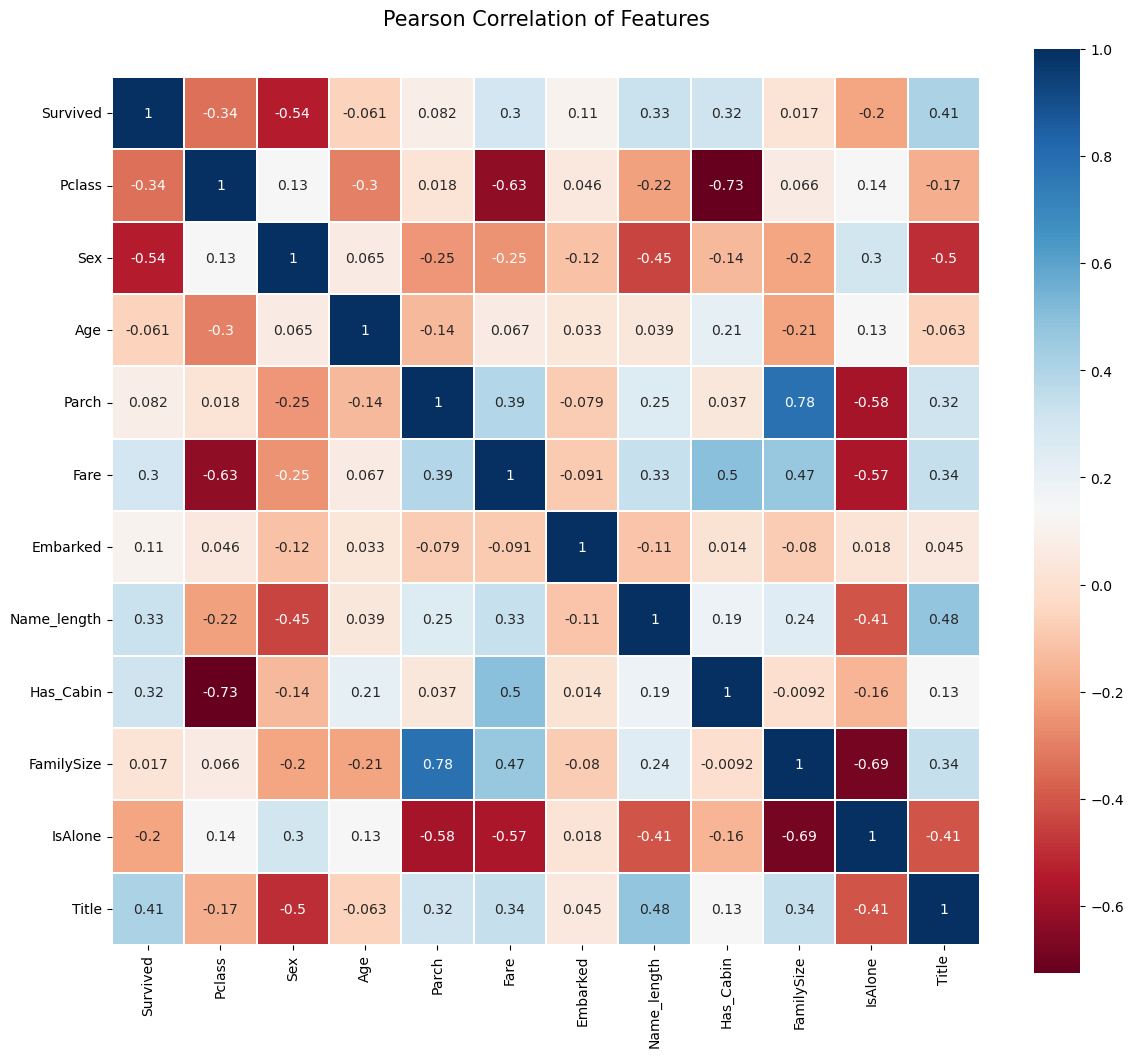

In [30]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

> - 플롯에서 얻을 수 있는 중요한 점은 피어슨 상관 관계 플롯에서 서로 강하게 상관되는 특성이 그리 많지 않다는 걸 확인. 학습 모델에 이러한 특성을 제공하는 관점에서 좋은 점인데, 왜냐하면 훈련 세트에 중복되거나 불필요한 데이터가 그리 많지 않다는 것을 의미하며, 각 특성이 어느 정도 고유한 정보를 갖고 있다는 것을 나타냄 가장 상관된 두 가지 특성은 FamilySize와 Parch(부모와 자녀)입니다. 이 연습의 목적을 위해 두 특성을 모두 남겨 둘 것

> - 마지막으로, 두 특성 간의 데이터 분포를 관찰하기 위해 일부 pairplot을 생성

C:\Users\daum0\anaconda3\lib\site-packages\seaborn\axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\daum0\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
C:\Users\daum0\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
C:\Users\daum0\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
C:\Users\daum0\anaconda3\lib\site-pac

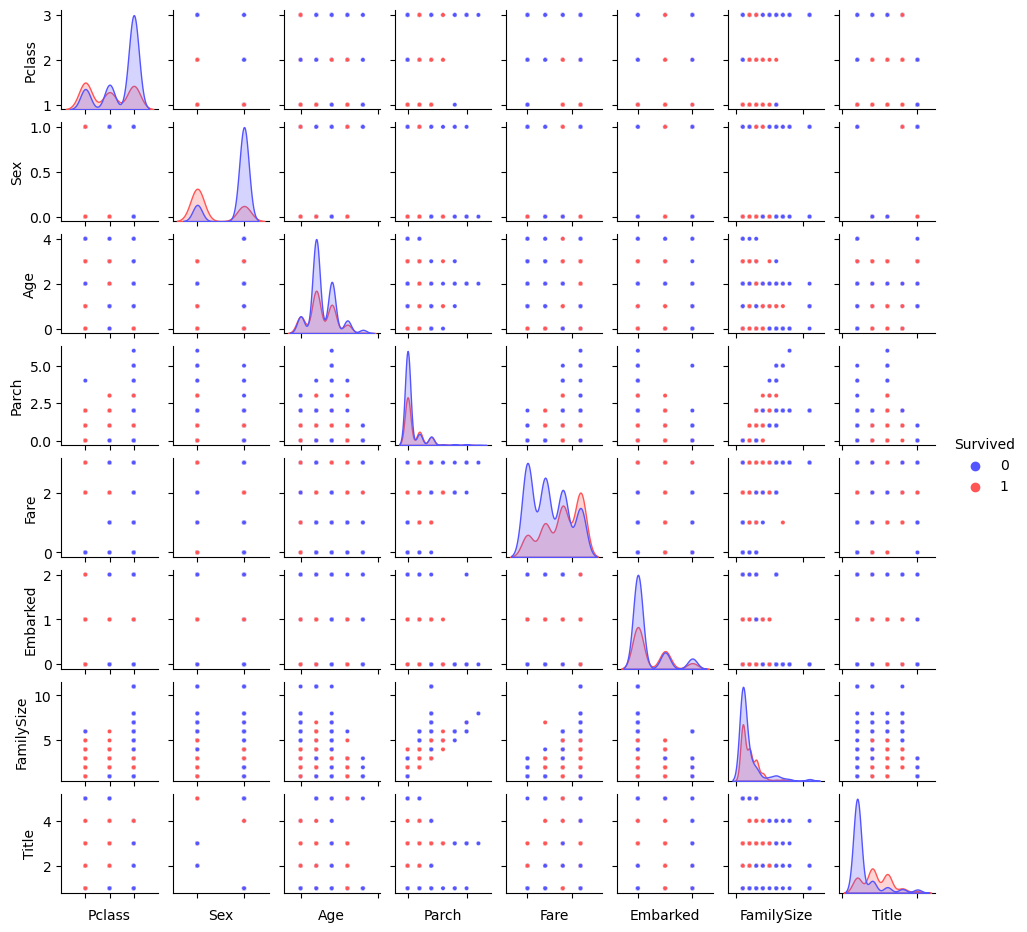

In [10]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

> - 편의를 위해 Python의 클래스를 사용.간단히 말해서, 클래스는 코드/프로그램을 확장하여 객체를 생성하고 해당 클래스에 특정한 함수와 메서드를 구현

> - 아래 코드 섹션에서는 SklearnHelper 클래스를 작성하여 모든 Sklearn 분류기에 공통된 내장 메서드(train, predict 및 fit과 같은)를 확장할 수 있도록 합니다. 따라서 이렇게 하면 여러 분류기를 사용하려면 동일한 메서드를 다섯 번 작성할 필요가 없으므로 중복을 제거할 수 있음

In [12]:
from sklearn.model_selection import KFold

In [31]:
# 나중에 유용하게 사용할 몇 가지 매개변수들
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # 재현성을 위한 시드
NFOLDS = 5 # out-of-fold 예측을 위한 폴드 설정
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)


# Sklearn 분류기를 확장하는 클래스
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.pre

> - 기본 분류기를 만들 때, 나는 이미 Sklearn 라이브러리에 있는 모델만 사용할 것이므로 해당 클래스만 확장

> - def init: 클래스의 기본 생성자를 호출하는 Python 표준, 이것은 객체(분류기)를 만들 때 clf(원하는 sklearn 분류기), seed(랜덤 시드) 및 params(분류기의 매개변수)를 지정해야 한다는 것을 의미.

> - 나머지 코드는 클래스의 메서드로, 단순히 Sklearn 분류기 내에 이미 존재하는 해당 메서드를 호출. 기본적으로, 우리는 여러 학습기를 스태커에 구현할 때 동일한 코드를 반복해서 작성하지 않도록 Sklearn 분류기를 확장하는 래퍼 클래스를 만들기

### Out-of-Fold Predictions
> 스태킹은 기본 분류기의 예측을 두 번째 수준 모델의 학습 입력으로 사용합니다. 그러나 기본 모델을 전체 훈련 데이터에 대해 간단히 학습시키고 전체 테스트 세트에 대한 예측을 생성한 다음 이를 두 번째 수준 학습에 사용하는 것은 적절하지 않습니다. 이렇게 하면 기본 모델 예측이 이미 테스트 세트를 "보았다"고 간주되어 이러한 예측을 피드하는 과정에서 과적합될 수 있기 때문입니다.

In [16]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# Generating our Base First-Level Models

이제 첫 번째 수준 분류로 다섯 가지 학습 모델을 준비해 보겠습니다. 이러한 모델은 모두 Sklearn 라이브러리를 통해 편리하게 호출할 수 있으며 다음과 같이 나열됩니다:

1. 랜덤 포레스트 분류기
2. 엑스트라 트리 분류기
3. 에이다부스트 분류기
4. 그래디언트 부스팅 분류기
5. 서포트 벡터 머신

**Parameters**

**n_jobs** : 훈련 프로세스에 사용되는 코어의 수. -1로 설정하면 모든 코어가 사용됩니다.\
**n_estimators** : 학습 모델의 분류 트리 수 (기본값은 10으로 설정됨)\
**max_depth** : 트리의 최대 깊이 또는 노드가 얼마나 확장되어야 하는지에 대한 값. 너무 높은 숫자로 설정하면 트리가 너무 깊게 성장하여 과적합의 위험이 있습니다.\
**verbose** : 학습 과정 중에 텍스트를 출력할지 여부를 제어합니다. 값이 0이면 모든 텍스트가 억제되고 값이 3이면 모든 반복에서 트리 학습 과정이 출력됩니다.\
**Sklearn** 공식 웹사이트를 통해 전체 설명을 확인하십시오. 거기에서는 실험해볼 수 있는 다양한 유용한 매개변수가 더 있음을 찾을 수 있습니다.

In [33]:
# 각 분류기에 대한 매개변수 설정

# 랜덤 포레스트 매개변수
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True, 
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# 엑스트라 트리 매개변수
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# 에이다부스트 매개변수
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# 그래디언트 부스팅 매개변수
gb_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# 서포트 벡터 머신 매개변수 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}

> - 앞서 정의한 Helper Sklearn 클래스를 통해 우리의 5가지 학습 모델을 나타내는 5개의 객체를 만들어 보겠습니다.

In [19]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

In [34]:
# 4개의 모델을 나타내는 5개의 객체 생성
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

### 원본 데이터프레임에서 NumPy 배열을 생성하여 분류기에 입력할 수 있는 훈련 및 테스트 데이터를 준비

In [35]:
# 모델에 입력하기 위해 train, test 및 target(Survived) 데이터프레임의 NumPy 배열 생성
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

### 첫 번째 수준 예측 결과

> - 이제 훈련 및 테스트 데이터를 5개의 기본 분류기에 입력하고 이전에 정의한 Out-of-Fold 예측 함수를 사용하여 첫 번째 수준 예측을 생성합니다.

In [36]:
# train 및 테스트 예측 생성. 이러한 기본 결과는 새로운 특성으로 사용
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

TypeError: get_oof() missing 1 required positional argument: 'kf'

**다른 분류기에서 생성된 특성 중요도**

이제 첫 번째 수준 분류기를 학습했으므로 Sklearn 모델의 매우 유용한 기능을 활용,

Sklearn 문서에 따르면 대부분의 분류기에는 .**feature_importances_** 를 입력하면 특성 중요도를 반환하는 속성이 내장, 따라서 우리는 이 매우 유용한 속성을 이전에 정의한 함수를 통해 호출하고 이를 사용하여 특성 중요도를 표현

In [ ]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

> - 아직 특성 중요도를 할당하고 저장하는 방법을 찾지 못했기 때문에 위의 코드에서 출력된 값을 직접 확인한 후 아래처럼 Python 리스트에 복사하여 붙여넣기

In [ ]:
rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591,  0.02854371
  ,0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
et_features = [ 0.12165657,  0.37098307  ,0.03129623 , 0.01591611 , 0.05525811 , 0.028157
  ,0.04589793 , 0.02030357 , 0.17289562 , 0.04853517,  0.08910063]
ada_features = [0.028 ,   0.008  ,      0.012   ,     0.05866667,   0.032 ,       0.008
  ,0.04666667 ,  0.     ,      0.05733333,   0.73866667,   0.01066667]
gb_features = [ 0.06796144 , 0.03889349 , 0.07237845 , 0.02628645 , 0.11194395,  0.04778854
  ,0.05965792 , 0.02774745,  0.07462718,  0.4593142 ,  0.01340093]

**Plotly 패키지를 통해 쉽게 그래픽을 그리기 위해 특성 중요도 데이터를 포함하는 리스트로부터 데이터프레임을 생성**

In [ ]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

**Plotly 패키지를 사용하여 다양한 분류기의 특성 중요도 값을 시각화하기 위해 "Scatter"를 호출하여 Plotly 산점도를 사용**

In [ ]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,  # y 축에는 랜덤 포레스트의 특성 중요도 값
    x = feature_dataframe['features'].values,  # x 축에는 특성 이름
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Random Forest feature importances'].values,  # 색상은 특성 중요도 값에 따라 지정
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values  # 마우스를 가져다 대면 특성 이름이 표시되도록 함
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# 이후에도 동일한 방식으로 Extra Trees, AdaBoost, Gradient Boo

In [ ]:
# 랜덤 포레스트의 특성 중요도를 나타내는 산점도
trace_rf = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data_rf = [trace_rf]

layout_rf = go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig_rf = go.Figure(data=data_rf, layout=layout_rf)
py.iplot(fig_rf, filename='scatter_rf')

# 엑스트라 트리의 특성 중요도를 나타내는 산점도
trace_et = go.Scatter(
    y = feature_dataframe['Extra Trees feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Extra Trees feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data_et = [trace_et]

layout_et = go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig_et = go.Figure(data=data_et, layout=layout_et)
py.iplot(fig_et, filename='scatter_et')

# 아다부스트의 특성 중요도를 나타내는 산점도
trace_ada = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data_ada = [trace_ada]

layout_ada = go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig_ada = go.Figure(data=data_ada, layout=layout_ada)
py.iplot(fig_ada, filename='scatter_ada')

# 그래디언트 부스팅의 특성 중요도를 나타내는 산점도
trace_gb = go.Scatter(
    y = feature_dataframe['Gradient Boosting feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Gradient Boosting feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data_gb = [trace_gb]

layout_gb = go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig_gb = go.Figure(data=data_gb, layout=layout_gb)
py.iplot(fig_gb, filename='scatter_gb')

**모든 특성 중요도의 평균을 계산하여 특성 중요도 데이터프레임에 새 열로 저장**

In [ ]:
# 값의 평균을 포함하는 새 열 생성
feature_dataframe['mean'] = feature_dataframe.mean(axis=1) # axis = 1은 행 방향으로 평균을 계산합니다.
feature_datafra

**Plotly 평균 특성 중요도 바 플롯**

모든 분류기를 통해 얻은 평균 특성 중요도를 가지고 있으므로, 이를 Plotly 바 플롯으로 그릴 수 있음

In [ ]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

## 일차 출력에서 두번째 수준 예측
**일차 출력을 새로운 특성으로 사용**
> - 이제 첫 번째 수준 예측을 얻었으니, 이것을 새로운 훈련 데이터 세트로 사용할 수 있도록 생각할 수 있습니다. 아래 코드에 따르면, 우리는 이전 분류기의 일차 예측을 새로운 열로 갖고 있으며, 다음 분류기를 이에 맞춰 훈련

In [ ]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

**두 번째 수준의 훈련 세트의 상관 관계 히트맵**

In [ ]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [ ]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

> - 첫 번째 수준의 훈련 및 테스트 예측을 x_train 및 x_test로 연결하고 결합했으므로, 이제 두 번째 수준의 학습 모델을 맞출 수 있습니다.

### XGBoost를 사용한 두 번째 수준의 학습 모델

> - XGBClassifier를 호출하고 첫 번째 수준의 훈련 및 대상 데이터에 적합하게 만들고 학습된 모델을 사용하여 다음과 같이 테스트 데이터를 예측

In [ ]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

 ### XGBoost 매개변수에 대한 간단한 설명

**max_depth** : 트리를 얼마나 깊게 키우고 싶은지를 결정합니다. 너무 높은 숫자로 설정하면 과적합의 위험이 있습니다.

**gamma** : 트리의 잎 노드에서 추가적인 분할을 수행하기 위해 필요한 최소 손실 감소량입니다. 이 값이 클수록 알고리즘은 더 보수적으로 작동합니다.

**eta** : 각 부스팅 단계에서 과적합을 방지하기 위해 사용되는 스텝 크기 축소율

In [ ]:
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)


### 추가 개선 단계

마무리로 위에서 취한 단계는 매우 간단한 앙상블 스태커를 생성하는 방법. 

> -점수를 향상시키기 위해 취할 수 있는 몇 가지 추가 단계는 
    1. 최적의 매개변수 값을 찾기 위해 모델을 훈련할 때 좋은 교차 검증 전략 구현
    2. 학습을 위해 더 많은 종류의 기본 모델 도입. 